In [134]:
import pandas
import matplotlib.pyplot as plt
from configparser import ConfigParser, ExtendedInterpolation
import json
from cycler import cycler

In [135]:
import random

In [136]:
def include_commit(df):
    #f['Commit'] = [1000]
    df.insert(loc=1, column='Commit', value=1000)
    return df

In [137]:
def load_and_clean(csv):
    df = pandas.read_csv(csv)
    #remove s after values
    selection = df.select_dtypes('object')
    for i in selection.columns:
        df[i] = df[i].str.replace('s', '')
        df[i] = df[i].astype(float)
    df = include_commit(df)
    i = 0
    while i < 10: #user will provide commit number to go back to here
        new_row = []
        for j in df.columns:
            if df[j].dtype == 'float64':
                rand_float = round(random.uniform(0.05, 10),2)
                new_row.append(rand_float)
            elif df[j].name == 'Threads run':
                rand_int = random.randint(100, 251)
                new_row.append(rand_int)
            elif df[j].name == 'Queries performed':
                rand_int = random.randint(500, 1000)
                new_row.append(rand_int)
            elif df[j].name == 'Rows printed to stdout or outfiles':
                rand_int = random.randint(1500, 2100)
                new_row.append(rand_int)
            elif df[j].name == 'Commit':
                rand_int = random.randint(10000, 70000)
                new_row.append(rand_int)
        df.loc[len(df)] = new_row
        df['Threads run'] = df['Threads run'].astype(int)
        df['Queries performed'] = df['Queries performed'].astype(int)
        df['Rows printed to stdout or outfiles'] = df['Rows printed to stdout or outfiles'].astype(int)
        df['Commit'] = df['Commit'].astype(int)
        df['Commit'] = df['Commit'].astype(str)
        i = i + 1
    return df

In [138]:
def plot_all(col):
    if col.name == 'Commit':
        return
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(df['Commit'].values.tolist(), col.values.tolist(), marker='o', linestyle='dashed')
    ax.set_title(f'{col.name}')
    if col.dtype == 'float64':
        ax.set_ylabel('Time(seconds)')
    elif col.name == 'Threads run':
        ax.set_ylabel('Threads')
    elif col.name == 'Queries performed':
        ax.set_ylabel('Queries')
    elif col.name == 'Rows printed to stdout or outfiles':
        ax.set_ylabel('Rows printed')
    ax.set_xlabel('Commit Hash')
    #annotate
    offset = 2
    for x,y in zip(df['Commit'].values.tolist(), col.values.tolist()):
        ax.annotate(f'{y}', (x,y), color='green', textcoords ='offset points',  xytext =(offset, offset))
    plt.show()

In [139]:
def generate_cycler(line_colors, line_types, markers):
    cycler_executer = '('
    if len(line_colors) != 0:
        cycler_executer = cycler_executer + "cycler(color=[line_colors[0]])"
        if len(line_types) !=0 or len(markers) !=0:
            cycler_executer = cycler_executer + " + "
    if len(line_types) != 0:
        cycler_executer = cycler_executer + "cycler(linestyle=[line_types[0]])"
        if len(markers) != 0:
            cycler_executer = cycler_executer + " + "
    if len(markers) != 0:
        cycler_executer = cycler_executer + "cycler(marker=[markers[0]])"
    cycler_executer = cycler_executer + ")"
    custom_cycler = eval(cycler_executer)
    if len(line_colors) != 0:
        line_colors.pop(0)
    if len(line_types) != 0:
        line_types.pop(0)
    if len(markers) != 0:
        markers.pop(0)
    return custom_cycler, line_colors, line_types, markers

In [202]:
def generate_graph(df, columns_to_plot, line_colors, graph_title, dimensions, line_types, markers, x_label, y_label, annotations, offset, text_color, default_text_color, png):
    fig, ax = plt.subplots(figsize=(dimensions[0], dimensions[1]))
    #default_style = ax._get_lines.color_cycle
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    #print(colors)
    #ax = plot_points(ax, columns_to_plot, marker, line_type, line_colors, df, annotations, text_color)
    for col in columns_to_plot:
        if len(line_colors) == 0:
            line_colors.extend(colors)
        if len(line_types) == 0:
            line_types.append('solid')
        if len(markers) == 0:
            markers.append('o')
        if len(line_colors) != 0 or len(line_types) != 0 or len(markers) != 0:
            custom_cycler, line_colors, line_types, markers = generate_cycler(line_colors, line_types, markers)
            ax.set_prop_cycle(custom_cycler)
            ax.plot(df['Commit'].values.tolist(), df[col].values.tolist())
        if annotations == True:
            for x, y in zip(df['Commit'].values.tolist(), df[col].values.tolist()): #This is a for loop for the marker and linestyle
                if len(text_color) == 0:
                    text_color.append(default_text_color)
                ax.annotate(f'{y}', (x,y), color=text_color[0], textcoords ='offset points',  xytext =(offset, offset))
            text_color.pop(0)
    if len(columns_to_plot) >= 2:
        ax.legend(columns_to_plot, bbox_to_anchor=(1,1), loc="upper left")
    ax.set_title(graph_title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.savefig(png)

## Main

In [203]:
parser = ConfigParser(interpolation=ExtendedInterpolation())
parser.read("configs/graph_config.ini") #user will provide this at command line

path_to_csv = parser.get('data', 'path_to_csv')
png = parser.get('data', 'save_to')

columns_to_plot = json.loads(parser.get('general', 'columns_to_plot'))
line_colors = json.loads(parser.get('general', 'line_colors'))
graph_title = parser.get('general', 'graph_title')
dimensions = json.loads(parser.get('general', 'dimension'))

line_type = json.loads(parser.get('line', 'line_type'))
marker = json.loads(parser.get('line', 'marker'))

x_label = parser.get('axes', 'x_label')
y_label = parser.get('axes', 'y_label')

annotations = parser.getboolean('annotations', 'annotations')
offset = parser.getint('annotations', 'offset')
text_color = json.loads(parser.get('annotations', 'text_color'))
default_text_color = parser.get('annotations', 'default_text_color')

#azimuth_list = json.loads(parser.get('azimuth_polar_list', 'azimuth_list'))

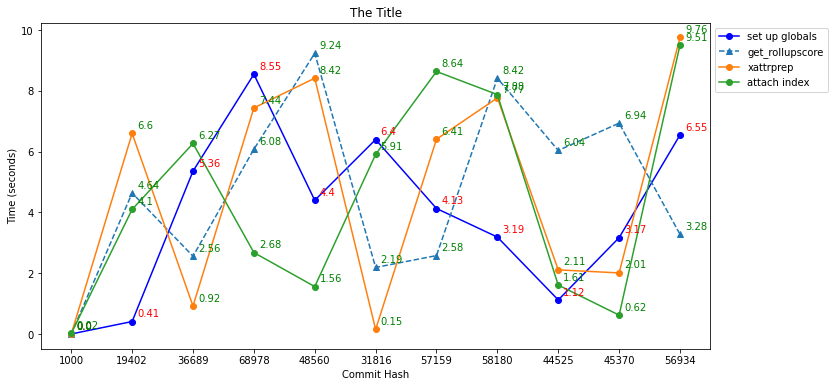

In [204]:
df = load_and_clean(path_to_csv)
generate_graph(df, columns_to_plot, line_colors, graph_title, dimensions, line_type, marker, x_label, y_label, annotations, offset, text_color, default_text_color, png)

In [ ]:
df.plot(figsize=(32, 24), subplots=True, layout=(5,10))

In [118]:
test = [1,2]
test1= [1,2,3]
test2 = [1]

x = max(test, test1, test2)
print(x)

[1, 2, 3]


In [119]:
test3 = [test[0]]
test3

[1]

In [1]:
test = []
len(test)

0

In [74]:
df

,set up globals,Commit,set up intermediate databases,thread pool,open directories,attach index,xattrprep,addqueryfuncs,get_rollupscore,descend,...,free work,output timestamps,aggregate into final databases,print aggregated results,clean up globals,Threads run,Queries performed,Rows printed to stdout or outfiles,Total Thread Time (not including main),Real time (main)
0,0.00,1000,0.00,0.06,0.00,0.02,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,192,960,1764,0.05,0.06
1,7.19,23588,2.63,6.86,7.98,8.50,2.62,0.35,5.37,8.27,...,3.65,4.89,9.88,9.57,8.05,154,875,1760,4.36,4.63
2,4.39,12255,6.66,0.49,1.43,7.76,0.99,1.01,6.12,5.05,...,3.07,0.61,7.76,1.52,8.87,165,902,1734,8.04,3.38
3,2.59,58408,7.05,1.72,7.23,3.55,7.48,0.99,2.59,3.66,...,5.79,6.32,0.70,3.39,2.04,191,857,1801,3.39,4.49
4,1.57,28720,1.18,0.73,9.49,1.03,0.82,9.56,3.06,7.06,...,5.37,2.30,8.48,7.45,2.86,229,674,1927,0.36,8.43
5,8.31,30526,3.43,3.67,2.73,5.88,4.98,3.62,3.37,7.28,...,1.98,0.20,7.45,8.40,6.28,229,509,1865,2.88,6.61
6,7.93,63243,5.93,1.36,4.49,0.15,8.16,4.03,5.64,5.61,...,1.59,8.11,8.27,7.55,4.44,138,948,1647,4.12,0.20
7,2.43,20369,8.57,2.31,3.55,7.72,0.69,3.94,7.83,6.62,...,5.26,1.53,6.94,5.43,1.74,154,948,1751,2.03,2.52
8,9.48,26254,8.05,4.13,8.64,6.73,6.97,7.68,7.68,7.62,...,6.59,7.52,9.56,8.16,1.42,121,907,1834,5.32,3.83
9,4.04,69726,0.78,3.13,3.24,1.18,6.86,8.14,2.76,6.71,...,5.74,9.43,1.51,3.58,1.16,239,890,1850,6.40,6.52
